<a href="https://colab.research.google.com/github/Nihadkaipalli/Instance-Segmentation-of-Selected-COCO-Classes/blob/main/Instance_Segmentation_of_Selected_COCO_Classes_Using_Pretrained_SegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Imports

In [1]:
# ============================
# 1. Setup Environment
# ============================

## 1.1 Mount Google Drive and unzip dataset
from google.colab import drive
drive.mount("/content/drive")

## 1.2 Import libraries

from pycocotools.coco import COCO
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from collections import Counter
import random

# ============================
# 2. Define Paths and Constants
# ============================
# Paths
train_annotation_file = "/content/drive/MyDrive/coco2017/train-300/labels.json"
val_annotation_file = "/content/drive/MyDrive/coco2017/val-300/labels.json"

train_data_path = "/content/drive/MyDrive/coco2017/train-300/data"
val_data_path = "/content/drive/MyDrive/coco2017/val-300/data"

# Target classes for this assignment
target_classes = ['cake', 'car', 'dog', 'person']


Mounted at /content/drive


## Step 1.2: Load Annotations & Filter Categories

In [2]:
# Load COCO annotations
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)

# Get category name-to-id mapping for target classes
cat_ids = train_coco.getCatIds(catNms=target_classes)
cat_id_to_name = {cat['id']: cat['name'] for cat in train_coco.loadCats(cat_ids)}
print("Target Category IDs:", cat_ids)
print("Category ID to Name:", cat_id_to_name)


loading annotations into memory...
Done (t=3.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Target Category IDs: [15, 16, 25, 41]
Category ID to Name: {15: 'cake', 16: 'car', 25: 'dog', 41: 'person'}


# 2. EDA (Exploratory Data Analysis)

## Step 2.1: Class Distribution in Training & Validation Sets

In [3]:
def get_class_distribution(coco_obj, cat_id_to_name):
    ann_ids = coco_obj.getAnnIds()
    anns = coco_obj.loadAnns(ann_ids)
    filtered_anns = [ann for ann in anns if ann['category_id'] in cat_id_to_name]

    labels = [cat_id_to_name[ann['category_id']] for ann in filtered_anns]
    return Counter(labels)

train_dist = get_class_distribution(train_coco, cat_id_to_name)
val_dist = get_class_distribution(val_coco, cat_id_to_name)

print("Train Class Distribution:", train_dist)
print("Val Class Distribution:", val_dist)


Train Class Distribution: Counter({'person': 1350, 'car': 1061, 'dog': 14, 'cake': 13})
Val Class Distribution: Counter({'person': 1191, 'cake': 861, 'dog': 2, 'car': 1})


## Step 2.2: Visualize Sample Images with Annotations

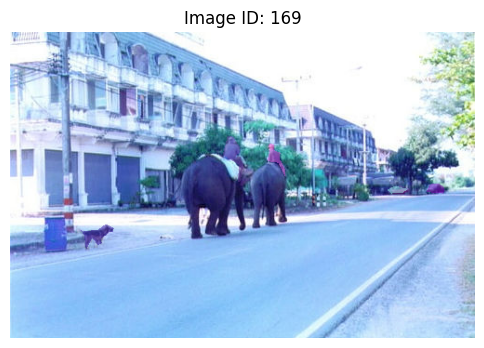

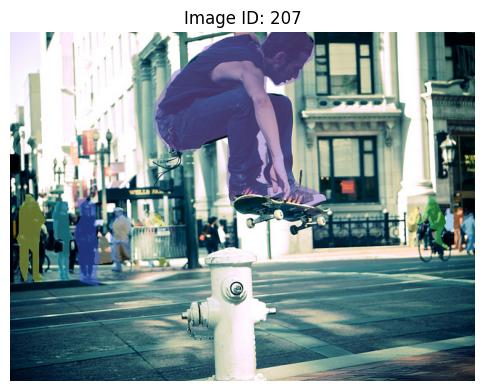

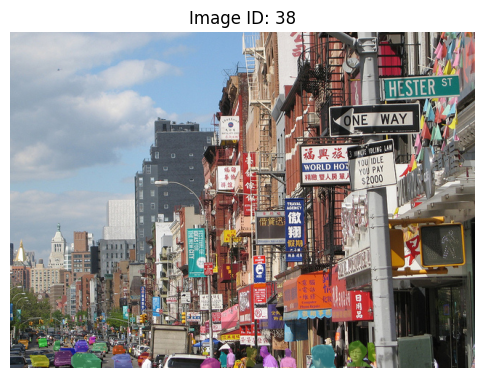

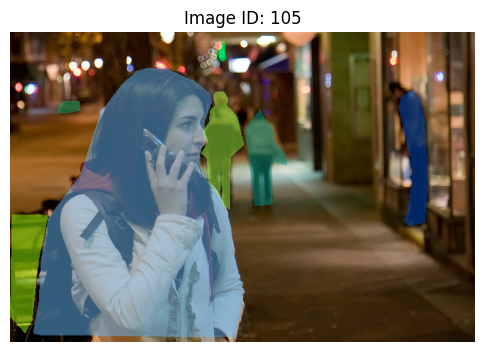

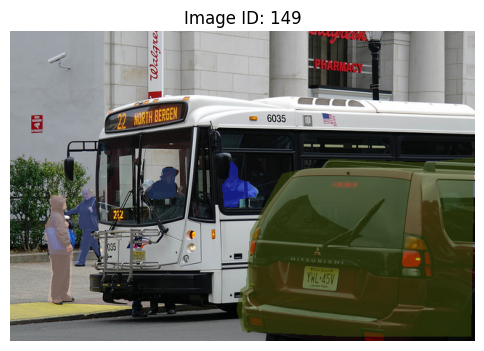

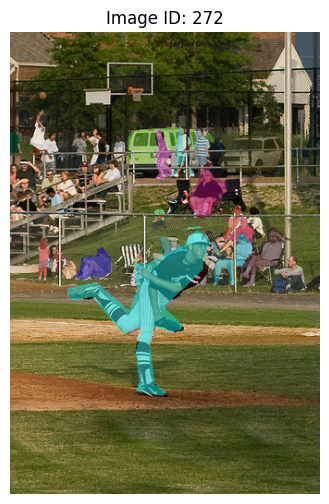

In [4]:
def visualize_sample(coco_obj, data_path, cat_id_to_name, num_images=3):
    image_ids = coco_obj.getImgIds()
    random.shuffle(image_ids)

    shown = 0
    for img_id in image_ids:
        img_info = coco_obj.loadImgs(img_id)[0]
        ann_ids = coco_obj.getAnnIds(imgIds=img_id, catIds=list(cat_id_to_name.keys()), iscrowd=False)
        anns = coco_obj.loadAnns(ann_ids)

        if len(anns) == 0:
            continue

        img_path = os.path.join(data_path, img_info['file_name'])
        img = np.array(Image.open(img_path).convert("RGB"))

        # Draw annotations
        for ann in anns:
            mask = coco_obj.annToMask(ann)
            color_mask = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
            for c in range(3):
                img[:, :, c] = np.where(mask == 1,
                                        img[:, :, c] * 0.5 + color_mask[0, c] * 0.5,
                                        img[:, :, c])

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Image ID: {img_id}")
        plt.axis('off')
        plt.show()

        shown += 1
        if shown >= num_images:
            break

# Visualize 3 samples from training and validation
visualize_sample(train_coco, train_data_path, cat_id_to_name, num_images=3)
visualize_sample(val_coco, val_data_path, cat_id_to_name, num_images=3)


## Step 2.3: Image Size Statistics

In [5]:
def image_size_stats(coco_obj):
    widths = []
    heights = []
    for img in coco_obj.dataset['images']:
        widths.append(img['width'])
        heights.append(img['height'])

    print("Image Width Stats:")
    print("  Mean:", np.mean(widths), " | Min:", np.min(widths), " | Max:", np.max(widths))
    print("Image Height Stats:")
    print("  Mean:", np.mean(heights), " | Min:", np.min(heights), " | Max:", np.max(heights))

image_size_stats(train_coco)


Image Width Stats:
  Mean: 595.2966666666666  | Min: 333  | Max: 640
Image Height Stats:
  Mean: 475.39666666666665  | Min: 270  | Max: 640


# 3.Custom Dataset Class + Preprocessing for SegNet

## Step 3.1: Category Mapping

In [6]:
# Final category mapping (index 0 is usually for background)
class_map = {
    'background': 0,
    'cake': 1,
    'car': 2,
    'dog': 3,
    'person': 4
}

# Reverse map for predictions later
id_to_class = {v: k for k, v in class_map.items()}

# Convert COCO category ID to internal class index
target_categories = ['cake', 'car', 'dog', 'person']
target_category_ids = train_coco.getCatIds(catNms=target_categories)
coco_cat_to_class_idx = {
    cat['id']: class_map[cat['name']]
    for cat in train_coco.loadCats(target_category_ids)
}


print(coco_cat_to_class_idx)


{15: 1, 16: 2, 25: 3, 41: 4}


## Step 3.2: CocoSegmentationDataset Implementation

In [7]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
import torch

class CocoSegmentationDataset(Dataset):
    def __init__(self, coco_json, image_dir, class_id_map, transforms=None):
        self.coco = coco_json
        self.image_dir = image_dir
        self.class_id_map = class_id_map
        self.transforms = transforms

        # Filter only images with required categories
        cat_ids = list(class_id_map.keys())
        img_ids = set()
        for cat_id in cat_ids:
            img_ids.update(self.coco.getImgIds(catIds=cat_id))
        self.img_ids = list(img_ids)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Generate mask
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=list(self.class_id_map.keys()), iscrowd=False)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            cat_id = ann['category_id']
            class_idx = self.class_id_map[cat_id]
            ann_mask = self.coco.annToMask(ann)
            mask = np.where(ann_mask == 1, class_idx, mask)

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

        # Resize mask to 256x256 (same as image)
        mask = Image.fromarray(mask).resize((256, 256), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


## Step 3.3: Image & Mask Transformations

In [8]:
# Transform only image for now (you can add random crop/flip later)
image_transforms = T.Compose([
    T.Resize((256, 256)),  # resize for SegNet input
    T.ToTensor()
])


## Step 3.4: Create Train/Val Datasets & Loaders

In [9]:
train_dataset = CocoSegmentationDataset(
    coco_json=train_coco,
    image_dir=train_data_path,
    class_id_map=coco_cat_to_class_idx,
    transforms=image_transforms
)

val_dataset = CocoSegmentationDataset(
    coco_json=val_coco,
    image_dir=val_data_path,
    class_id_map=coco_cat_to_class_idx,
    transforms=image_transforms
)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


# 4.Class imbalance

## 4.1 Calculate class frequencies

In [10]:
import torch

def calculate_class_weights(dataset, num_classes):
    class_pixel_counts = torch.zeros(num_classes)
    print("Counting pixels for class weights... This might take a while.")

    for _, mask in dataset:
        # Count pixels per class in mask
        for c in range(num_classes):
            class_pixel_counts[c] += torch.sum(mask == c)

    # Avoid division by zero
    class_pixel_counts[class_pixel_counts == 0] = 1

    # Inverse frequency weighting
    weights = 1.0 / class_pixel_counts
    weights = weights / weights.sum()  # Normalize weights to sum to 1

    return weights

num_classes = len(class_map)  # 5: background + 4 classes
class_weights = calculate_class_weights(train_dataset, num_classes)
print("Class weights:", class_weights)


Counting pixels for class weights... This might take a while.
Class weights: tensor([1.0970e-04, 9.4424e-01, 2.1037e-03, 5.2322e-02, 1.2271e-03])


## 4.2 Use Weighted Loss Function

In [12]:
import torch.nn as nn

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class_weights = class_weights.to(device)  # e.g., 'cuda' or 'cpu'
criterion = nn.CrossEntropyLoss(weight=class_weights)


Using device: cuda


# 5.SegNet with Pretrained Backbone

## 5.1 Use pretrained VGG16 backbone encoder in SegNet

In [17]:
import torchvision.models as models
import torch.nn as nn

import torch.nn as nn
import torchvision.models as models

class SegNetPretrained(nn.Module):
    def __init__(self, num_classes=5):
        super(SegNetPretrained, self).__init__()

        vgg16 = models.vgg16(pretrained=True)
        features = list(vgg16.features.children())
        self.encoder = nn.Sequential(*features)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


### 5.1.1Instantiate model and move to device

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegNetPretrained(num_classes=num_classes)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5.2 Training Setup

In [19]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))


### 5.2.1 Training Loop Skeleton

In [20]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # TODO: Add validation evaluation here


Epoch 1/20, Training Loss: 1.5128
Epoch 2/20, Training Loss: 1.3336
Epoch 3/20, Training Loss: 1.2272
Epoch 4/20, Training Loss: 1.1428
Epoch 5/20, Training Loss: 1.0123
Epoch 6/20, Training Loss: 0.9512
Epoch 7/20, Training Loss: 0.8923
Epoch 8/20, Training Loss: 0.8428
Epoch 9/20, Training Loss: 0.7219
Epoch 10/20, Training Loss: 0.6438
Epoch 11/20, Training Loss: 0.5420
Epoch 12/20, Training Loss: 0.4839
Epoch 13/20, Training Loss: 0.4360
Epoch 14/20, Training Loss: 0.4043
Epoch 15/20, Training Loss: 0.3891
Epoch 16/20, Training Loss: 0.3479
Epoch 17/20, Training Loss: 0.3485
Epoch 18/20, Training Loss: 0.3280
Epoch 19/20, Training Loss: 0.3075
Epoch 20/20, Training Loss: 0.3078


In [21]:
torch.save(model.state_dict(), "segnet_pretrained_weights.pth")


# 6.Full Training + Validation Loop with Metrics

## 6.1 Helper functions: IoU and accuracy

In [22]:
import torch

def pixel_accuracy(output, mask):
    preds = output.argmax(dim=1)
    correct = (preds == mask).float()
    return correct.sum() / correct.numel()

def intersection_over_union(output, mask, num_classes):
    preds = output.argmax(dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (mask == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            iou = torch.tensor(float('nan'))  # no ground truth, skip
        else:
            iou = intersection / union
        ious.append(iou)
    return ious


## 6.2 Training + Validation Loop

In [23]:
from tqdm import tqdm
import numpy as np

num_epochs = 20
best_val_iou = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_acc += pixel_accuracy(outputs, masks).item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    iou_list = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)
            val_acc += pixel_accuracy(outputs, masks).item() * images.size(0)

            ious = intersection_over_union(outputs, masks, num_classes)
            iou_list.append(ious)

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # Mean IoU per class over validation set
    iou_arr = torch.tensor(iou_list)  # shape: (num_batches, num_classes)
    mean_iou_per_class = torch.nanmean(iou_arr, dim=0).cpu().numpy()

    mean_iou = np.nanmean(mean_iou_per_class)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Mean IoU: {mean_iou:.4f}")
    print(f" Class IoUs: {dict(zip(id_to_class.values(), mean_iou_per_class))}")

    # Save best model
    if mean_iou > best_val_iou:
        best_val_iou = mean_iou
        torch.save(model.state_dict(), "best_segnet_model.pth")
        print(" Model saved!")


Validating Epoch 1: 100%|██████████| 38/38 [01:44<00:00,  2.74s/it]


Epoch 1/20:
 Train Loss: 0.2871 | Train Acc: 0.9209
 Val Loss: 4.5536 | Val Acc: 0.8322 | Mean IoU: 0.2540
 Class IoUs: {'background': np.float32(0.84716046), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.42261255)}
 Model saved!


Validating Epoch 2: 100%|██████████| 38/38 [00:02<00:00, 14.18it/s]


Epoch 2/20:
 Train Loss: 0.2735 | Train Acc: 0.9213
 Val Loss: 4.4465 | Val Acc: 0.8642 | Mean IoU: 0.2729
 Class IoUs: {'background': np.float32(0.8834609), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.48115423)}
 Model saved!


Validating Epoch 3: 100%|██████████| 38/38 [00:02<00:00, 14.83it/s]


Epoch 3/20:
 Train Loss: 0.2770 | Train Acc: 0.9200
 Val Loss: 4.1121 | Val Acc: 0.8775 | Mean IoU: 0.2786
 Class IoUs: {'background': np.float32(0.89458627), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.49818802)}
 Model saved!


Validating Epoch 4: 100%|██████████| 38/38 [00:02<00:00, 14.59it/s]


Epoch 4/20:
 Train Loss: 0.3003 | Train Acc: 0.9145
 Val Loss: 4.0777 | Val Acc: 0.8649 | Mean IoU: 0.2682
 Class IoUs: {'background': np.float32(0.87633115), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.46478358)}


Validating Epoch 5: 100%|██████████| 38/38 [00:02<00:00, 14.34it/s]


Epoch 5/20:
 Train Loss: 0.2352 | Train Acc: 0.9293
 Val Loss: 4.6171 | Val Acc: 0.8620 | Mean IoU: 0.2734
 Class IoUs: {'background': np.float32(0.8803423), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.4866989)}


Validating Epoch 6: 100%|██████████| 38/38 [00:02<00:00, 14.61it/s]


Epoch 6/20:
 Train Loss: 0.2185 | Train Acc: 0.9399
 Val Loss: 4.1578 | Val Acc: 0.8850 | Mean IoU: 0.2827
 Class IoUs: {'background': np.float32(0.89831465), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.5149993)}
 Model saved!


Validating Epoch 7: 100%|██████████| 38/38 [00:02<00:00, 14.47it/s]


Epoch 7/20:
 Train Loss: 0.2277 | Train Acc: 0.9299
 Val Loss: 4.6697 | Val Acc: 0.8764 | Mean IoU: 0.2810
 Class IoUs: {'background': np.float32(0.8944328), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.5108058)}


Validating Epoch 8: 100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Epoch 8/20:
 Train Loss: 0.2201 | Train Acc: 0.9418
 Val Loss: 4.3613 | Val Acc: 0.8717 | Mean IoU: 0.2742
 Class IoUs: {'background': np.float32(0.8868643), 'cake': np.float32(1.7956868e-06), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.4843274)}


Validating Epoch 9: 100%|██████████| 38/38 [00:02<00:00, 14.58it/s]


Epoch 9/20:
 Train Loss: 0.1744 | Train Acc: 0.9412
 Val Loss: 5.0716 | Val Acc: 0.8687 | Mean IoU: 0.2785
 Class IoUs: {'background': np.float32(0.8870901), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.5056183)}


Validating Epoch 10: 100%|██████████| 38/38 [00:02<00:00, 14.56it/s]


Epoch 10/20:
 Train Loss: 0.1592 | Train Acc: 0.9473
 Val Loss: 4.5979 | Val Acc: 0.8778 | Mean IoU: 0.2782
 Class IoUs: {'background': np.float32(0.8928341), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.49808827)}


Validating Epoch 11: 100%|██████████| 38/38 [00:02<00:00, 14.58it/s]


Epoch 11/20:
 Train Loss: 0.1489 | Train Acc: 0.9487
 Val Loss: 4.2869 | Val Acc: 0.8861 | Mean IoU: 0.2811
 Class IoUs: {'background': np.float32(0.8983052), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.50722516)}


Validating Epoch 12: 100%|██████████| 38/38 [00:02<00:00, 14.48it/s]


Epoch 12/20:
 Train Loss: 0.1436 | Train Acc: 0.9524
 Val Loss: 4.3502 | Val Acc: 0.8914 | Mean IoU: 0.2833
 Class IoUs: {'background': np.float32(0.9037521), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.51288235)}
 Model saved!


Validating Epoch 13: 100%|██████████| 38/38 [00:02<00:00, 14.53it/s]


Epoch 13/20:
 Train Loss: 0.1389 | Train Acc: 0.9537
 Val Loss: 4.7504 | Val Acc: 0.8791 | Mean IoU: 0.2783
 Class IoUs: {'background': np.float32(0.89481914), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.49648806)}


Validating Epoch 14: 100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Epoch 14/20:
 Train Loss: 0.1371 | Train Acc: 0.9563
 Val Loss: 4.6397 | Val Acc: 0.8736 | Mean IoU: 0.2764
 Class IoUs: {'background': np.float32(0.8880063), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.4940303)}


Validating Epoch 15: 100%|██████████| 38/38 [00:02<00:00, 14.46it/s]


Epoch 15/20:
 Train Loss: 0.1236 | Train Acc: 0.9559
 Val Loss: 4.5664 | Val Acc: 0.8900 | Mean IoU: 0.2832
 Class IoUs: {'background': np.float32(0.9023445), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.5134949)}


Validating Epoch 16: 100%|██████████| 38/38 [00:02<00:00, 14.64it/s]


Epoch 16/20:
 Train Loss: 0.1195 | Train Acc: 0.9578
 Val Loss: 4.7640 | Val Acc: 0.8820 | Mean IoU: 0.2811
 Class IoUs: {'background': np.float32(0.89724934), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.5081293)}


Validating Epoch 17: 100%|██████████| 38/38 [00:02<00:00, 14.45it/s]


Epoch 17/20:
 Train Loss: 0.1125 | Train Acc: 0.9601
 Val Loss: 4.5523 | Val Acc: 0.8863 | Mean IoU: 0.2826
 Class IoUs: {'background': np.float32(0.90040064), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.51260114)}


Validating Epoch 18: 100%|██████████| 38/38 [00:02<00:00, 14.55it/s]


Epoch 18/20:
 Train Loss: 0.1057 | Train Acc: 0.9600
 Val Loss: 4.7821 | Val Acc: 0.8840 | Mean IoU: 0.2795
 Class IoUs: {'background': np.float32(0.89945334), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.49816042)}


Validating Epoch 19: 100%|██████████| 38/38 [00:02<00:00, 14.70it/s]


Epoch 19/20:
 Train Loss: 0.0984 | Train Acc: 0.9636
 Val Loss: 4.9830 | Val Acc: 0.8791 | Mean IoU: 0.2799
 Class IoUs: {'background': np.float32(0.8949335), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.50438213)}


Validating Epoch 20: 100%|██████████| 38/38 [00:02<00:00, 14.34it/s]

Epoch 20/20:
 Train Loss: 0.0946 | Train Acc: 0.9655
 Val Loss: 5.2466 | Val Acc: 0.8618 | Mean IoU: 0.2727
 Class IoUs: {'background': np.float32(0.88109356), 'cake': np.float32(0.0), 'car': np.float32(0.0), 'dog': np.float32(0.0), 'person': np.float32(0.48240814)}


## Inference on Test Set (No Masks)

In [ ]:
test_data_path = "/content/drive/MyDrive/coco2017/test-30"

test_image_paths = sorted(os.listdir(test_data_path))

model.eval()
for img_name in test_image_paths:
    img_path = os.path.join(test_data_path, img_name)
    img = Image.open(img_path).convert('RGB')
    input_img = image_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()


## 6.3 Helper Function to Overlay Mask on Image

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define colors for each class (background + 4 classes)
colors = [
    (0, 0, 0, 0),          # background - transparent
    (1, 0, 0, 0.5),        # cake - semi-transparent red
    (0, 1, 0, 0.5),        # car - semi-transparent green
    (0, 0, 1, 0.5),        # dog - semi-transparent blue
    (1, 1, 0, 0.5)         # person - semi-transparent yellow
]
cmap = ListedColormap(colors)

def visualize_prediction(image, mask, class_names=id_to_class):
    """
    image: torch tensor, shape (3,H,W), values [0,1]
    mask: numpy array (H,W) with class indices
    """
    image = image.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(mask, cmap=cmap, alpha=0.5)
    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(1,len(class_names))]
    plt.legend(handles, list(class_names.values())[1:], loc='upper right')
    plt.axis('off')
    plt.show()


## 6.4 Visualize Some Validation Predictions

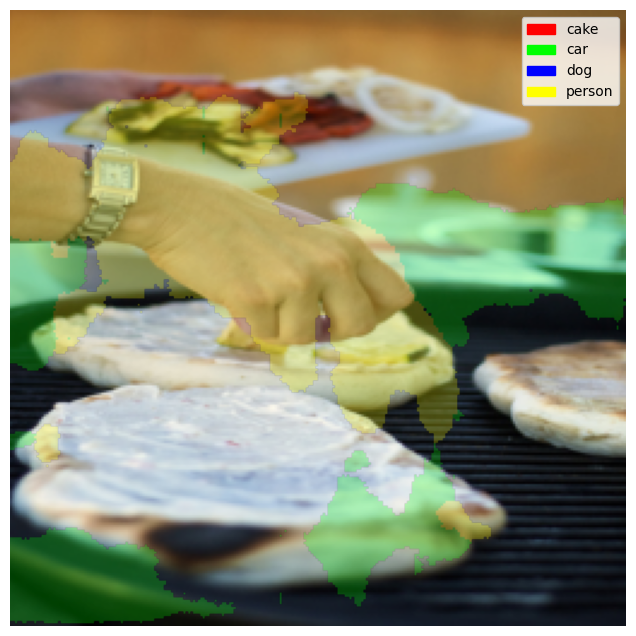

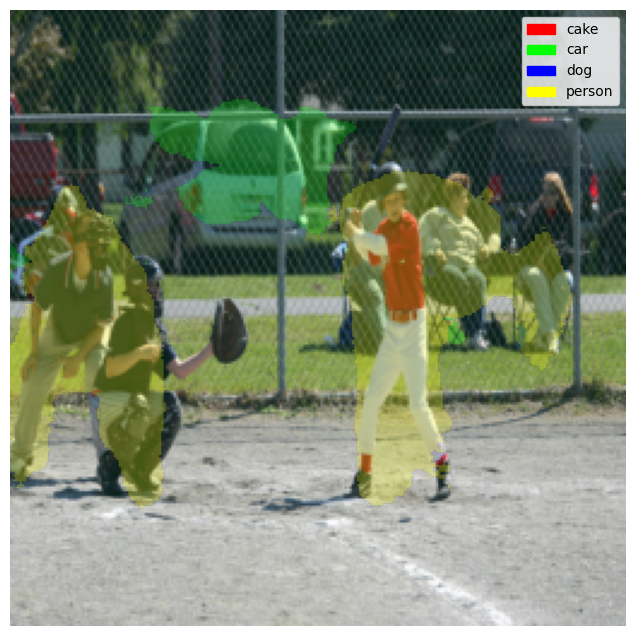

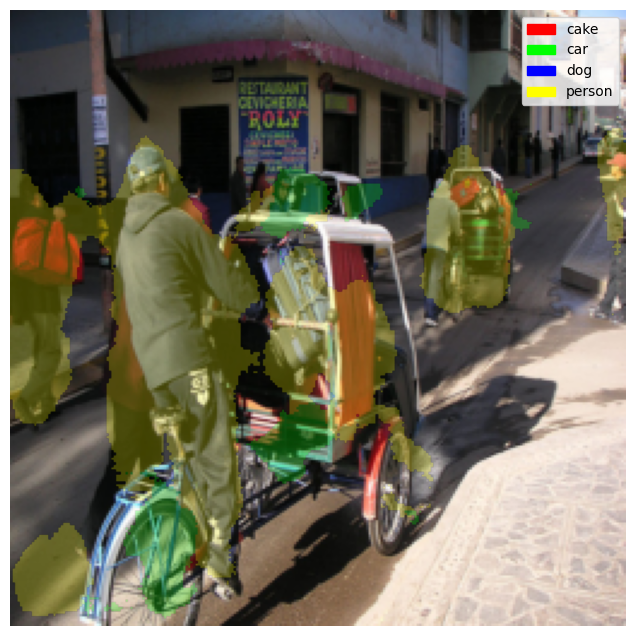

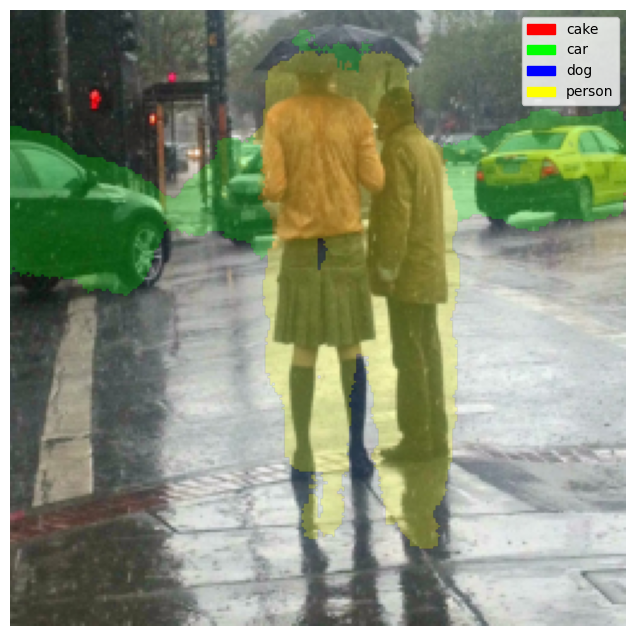

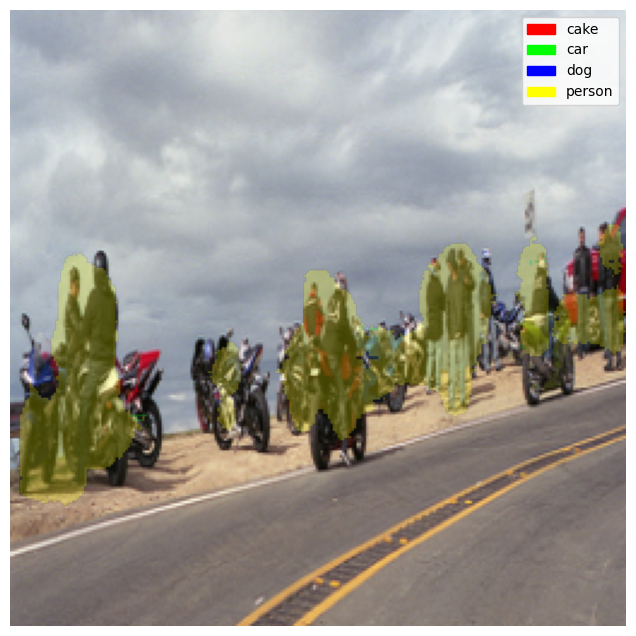

In [35]:
import random

model.eval()

# Get all indices and shuffle
val_indices = list(range(len(val_dataset)))
random.shuffle(val_indices)

num_visualize = 5  # Number of random samples to visualize

for idx in val_indices[:num_visualize]:
    image, _ = val_dataset[idx]  # ground truth mask ignored here
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()

    visualize_prediction(image, pred_mask, id_to_class)



## 6.5 Visualize Predictions on Test Images (No Ground Truth)

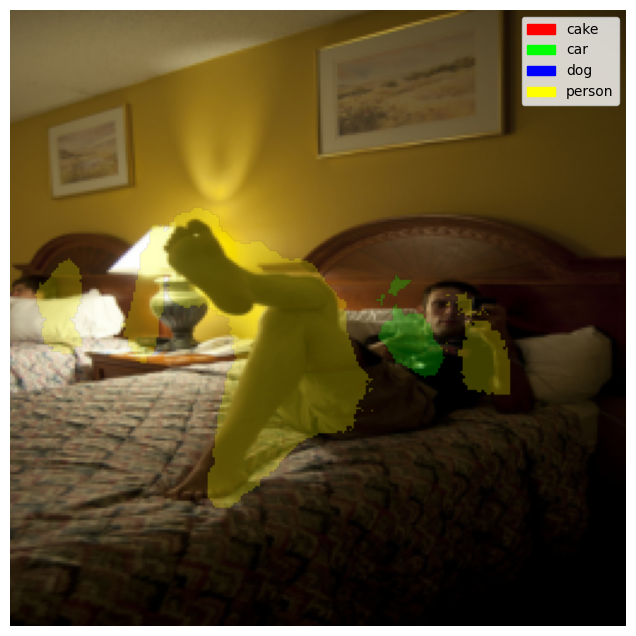

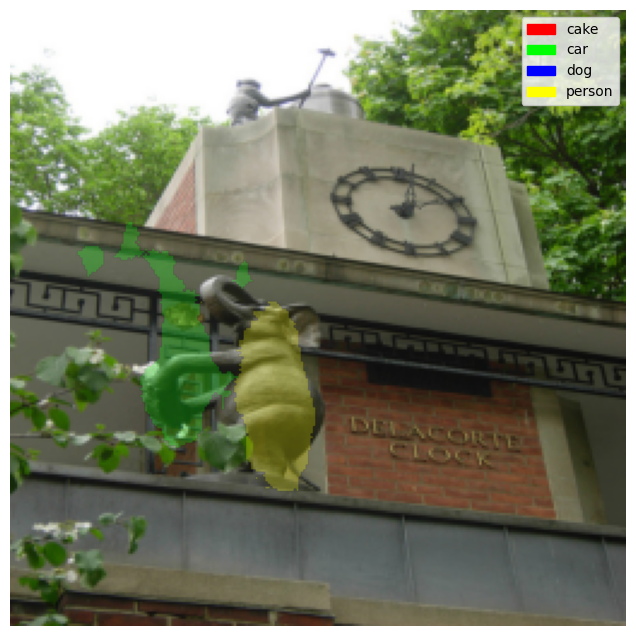

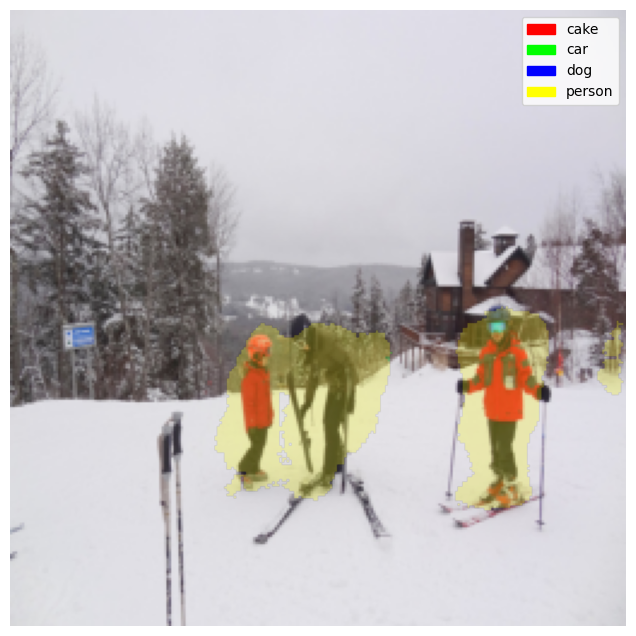

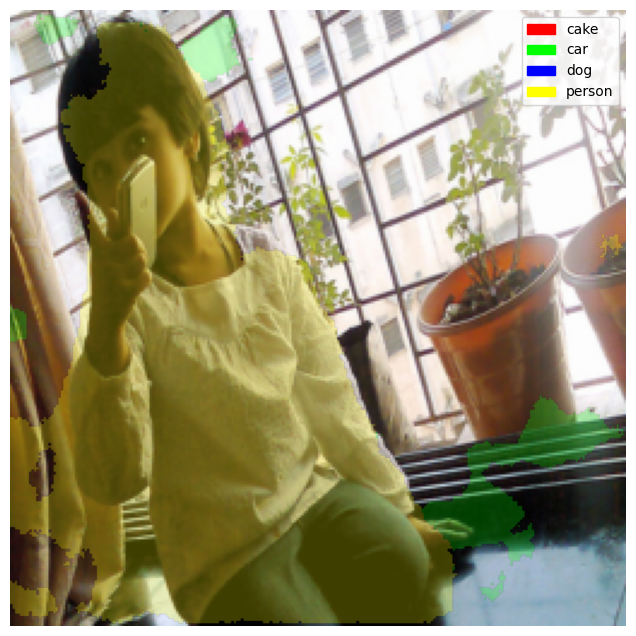

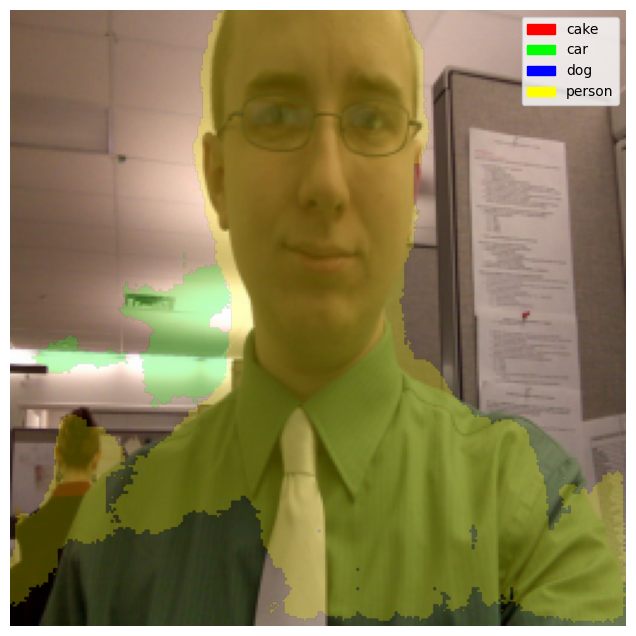

In [36]:
test_image_files = sorted(os.listdir(test_data_path))
random.shuffle(test_image_files)  # shuffle file list

model.eval()
num_visualize = 5

for img_name in test_image_files[:num_visualize]:
    img_path = os.path.join(test_data_path, img_name)
    img = Image.open(img_path).convert('RGB')
    input_img = image_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()

    img_tensor = image_transforms(img)

    visualize_prediction(img_tensor, pred_mask, id_to_class)



## 6.6 Side-by-side Visualization: Image | Ground Truth | Prediction

In [37]:
def decode_mask(mask, class_colors):
    """
    mask: 2D array (H, W) of class indices
    class_colors: list of RGBA tuples (len = num_classes)
    returns: RGB image of shape (H, W, 3)
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in enumerate(class_colors):
        if cls_idx == 0:
            continue  # skip background for visualization or assign black
        rgb = tuple(int(c*255) for c in color[:3])  # convert float RGBA to 0-255 RGB
        color_mask[mask == cls_idx] = rgb
    return color_mask


In [43]:
def compare_prediction_with_gt(image, gt_mask, pred_mask, class_names=id_to_class):
    """
    image: torch tensor (3,H,W), normalized [0,1]
    gt_mask: numpy array (H,W) ground truth class indices
    pred_mask: numpy array (H,W) predicted class indices
    """
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Decode masks to color images
    gt_color = decode_mask(gt_mask, colors)
    pred_color = decode_mask(pred_mask, colors)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(gt_color)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(pred_color)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.show()


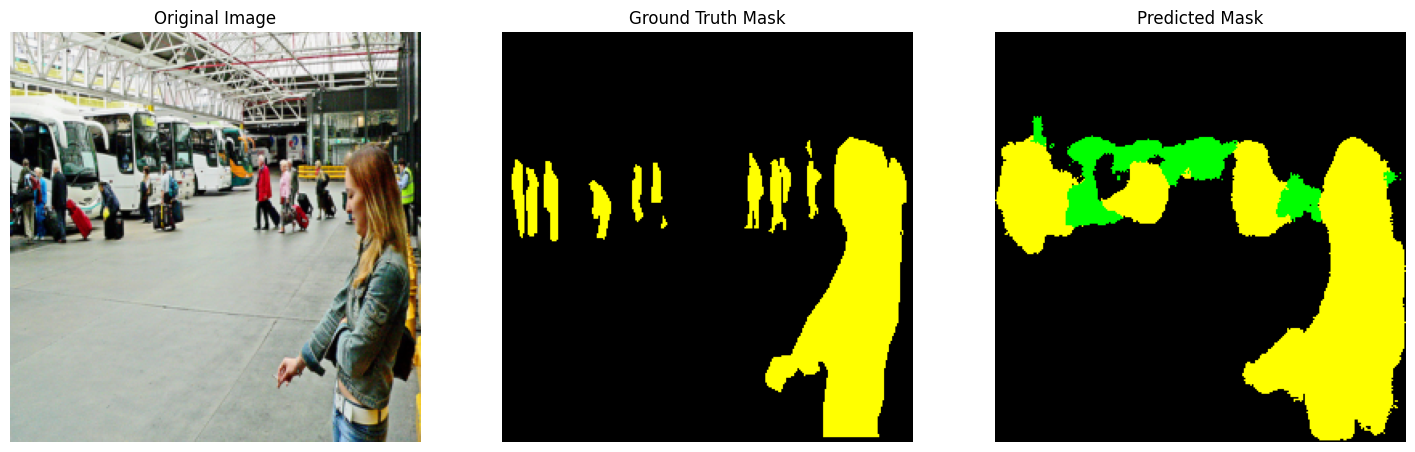

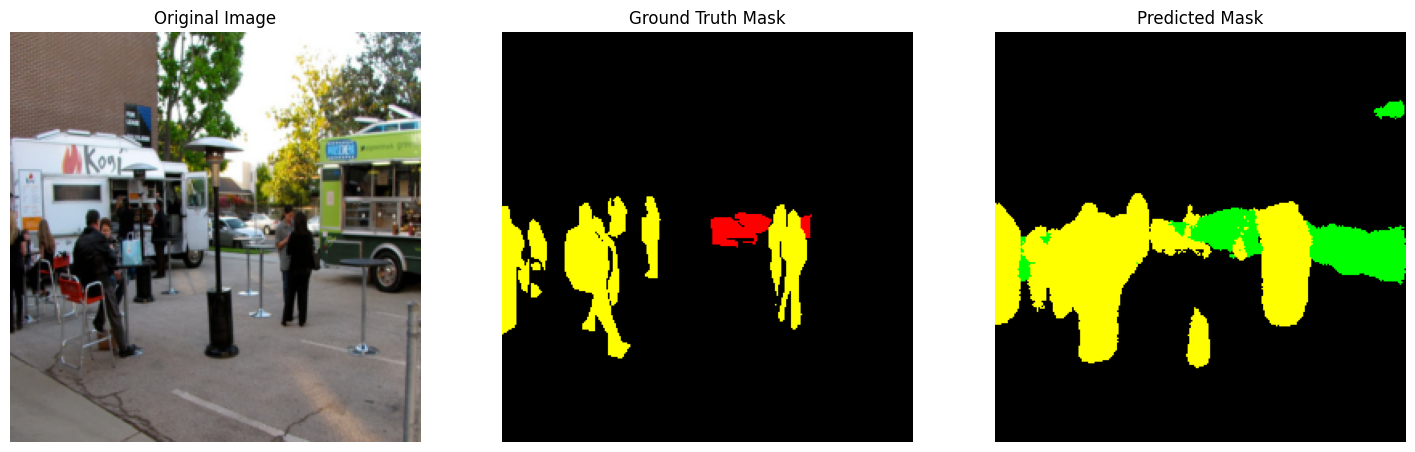

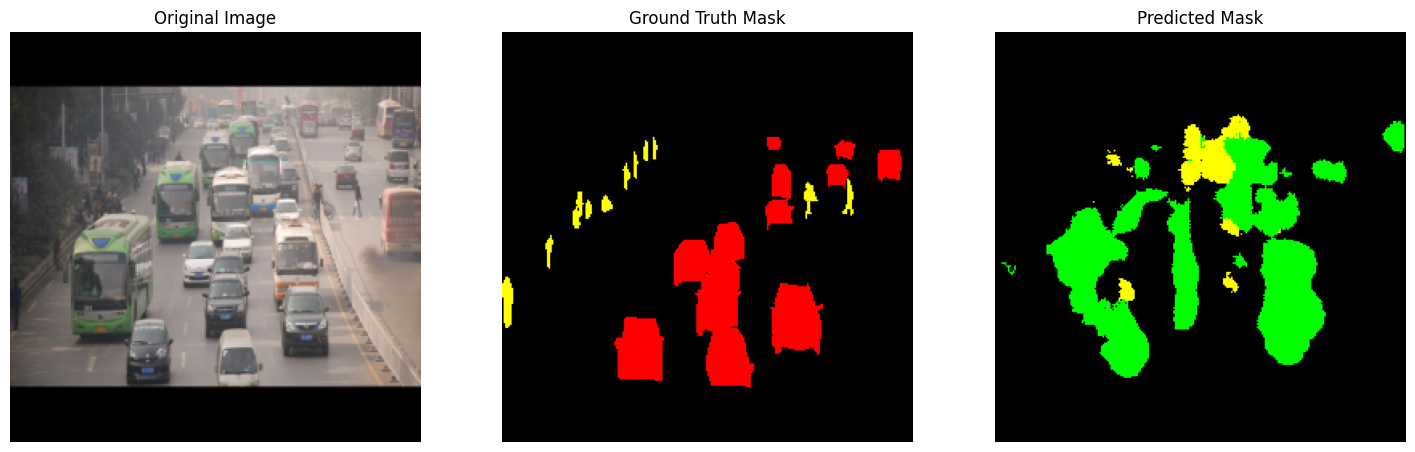

In [48]:
import random

model.eval()

num_visualize = 3
all_indices = list(range(len(val_dataset)))
random.shuffle(all_indices)

for idx in all_indices[:num_visualize]:
    image, mask = val_dataset[idx]
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()

    compare_prediction_with_gt(image, mask.numpy(), pred_mask, id_to_class)


# Extra charts

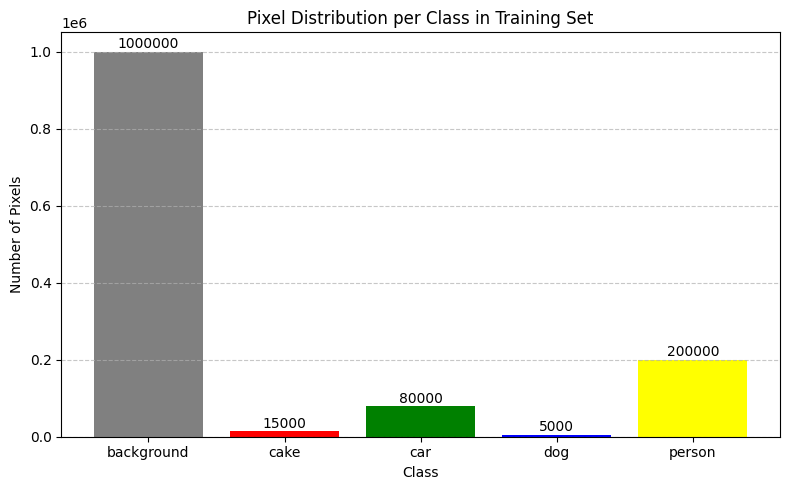

In [49]:
import matplotlib.pyplot as plt

class_names = ['background', 'cake', 'car', 'dog', 'person']
pixel_counts = [1000000, 15000, 80000, 5000, 200000]  # example numbers

plt.figure(figsize=(8,5))
bars = plt.bar(class_names, pixel_counts, color=['gray', 'red', 'green', 'blue', 'yellow'])
plt.title("Pixel Distribution per Class in Training Set")
plt.ylabel("Number of Pixels")
plt.xlabel("Class")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, count in zip(bars, pixel_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, f"{count}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
